In [2]:
import pandas as pd

In [3]:
bioclimatic_data = pd.read_csv('PA-train-bioclimatic.csv')
merged_data = pd.read_csv('cluster_with_pollution_data.csv')

In [4]:
print(bioclimatic_data.columns)

Index(['surveyId', 'Bio1', 'Bio2', 'Bio3', 'Bio4', 'Bio5', 'Bio6', 'Bio7',
       'Bio8', 'Bio9', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15',
       'Bio16', 'Bio17', 'Bio18', 'Bio19'],
      dtype='object')


# Particle Swarm Optimization

Selected species IDs: [6874]
Stopping search: maximum iterations reached --> 100
Recommended Cluster: 4044, Score: 1e+100


C:\Users\abhis\AppData\Local\Temp\ipykernel_20572\3922622507.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(best_cluster), float(best_score)  # Return as scalar values
C:\Users\abhis\AppData\Local\Temp\ipykernel_20572\3922622507.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Clusters (sample)')


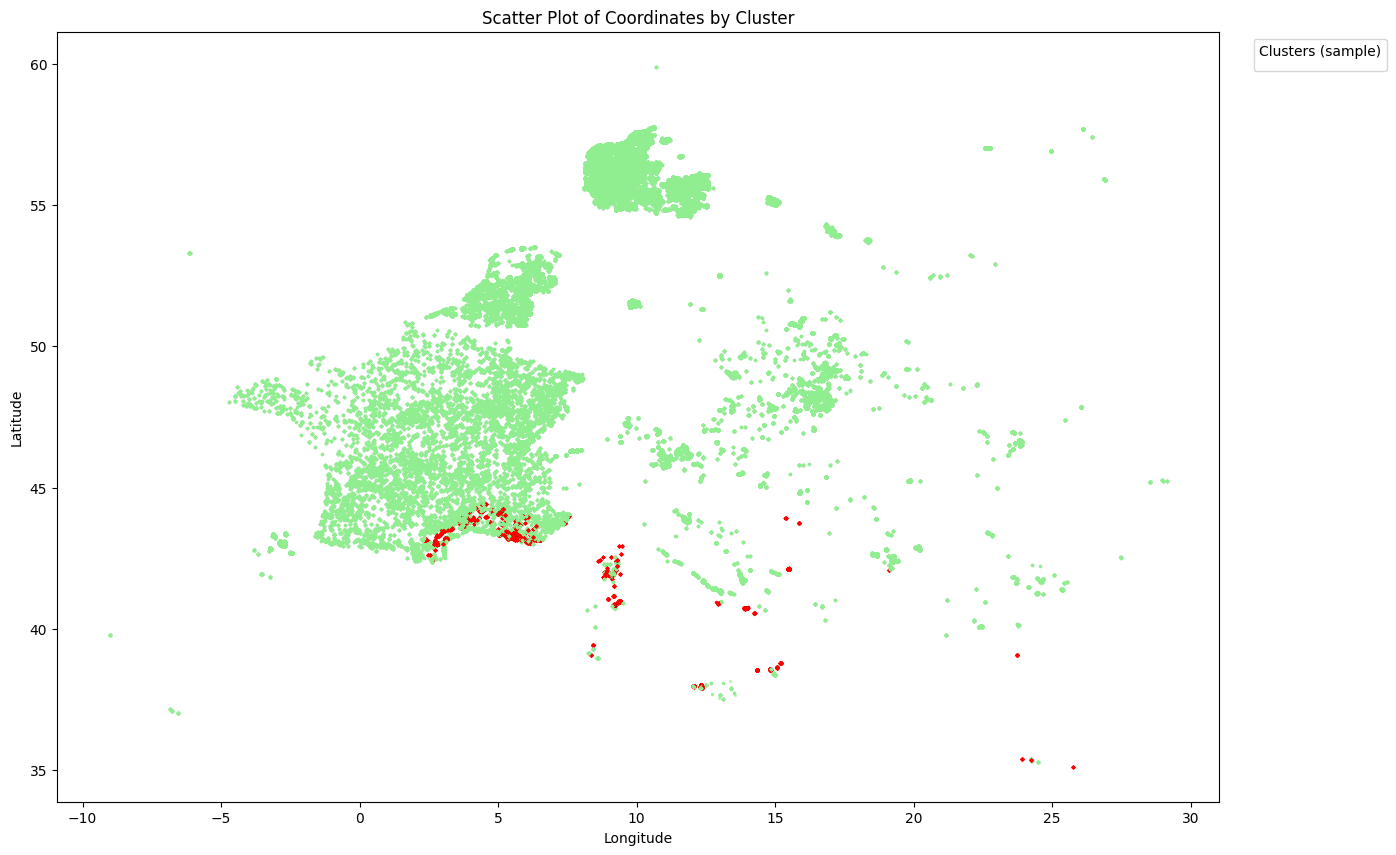

In [8]:
import pandas as pd
import ast  # To parse string representation of lists into actual lists
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pyswarm import pso
import random
from scipy.spatial import ConvexHull

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define a function to calculate the fitness of a cluster
def fitness_function(cluster, merged_data, bioclimatic_data):
    # Extract relevant pollution data for the cluster
    cluster_data = merged_data[merged_data['cluster'] == cluster]
    
    # Calculate a score based on AQI and other pollutants (lower is better)
    score = 0
    if not cluster_data.empty:
        score += cluster_data['AQI'].mean() * 0.4  # Weight for AQI
        score += cluster_data['CO'].mean() * 0.2   # Weight for CO
        score += cluster_data['NO2'].mean() * 0.2  # Weight for NO2
        score += cluster_data['PM2.5'].mean() * 0.2 # Weight for PM2.5
        
        # Add bioclimatic variable (e.g., Bio1)
        survey_id = cluster_data['surveyId'].values[0]  # Get the surveyId from the first entry
        bio1_mean = bioclimatic_data[bioclimatic_data['surveyId'] == survey_id]['Bio1'].mean()
        score += bio1_mean * 0.1  # Weight for Bio1
    
    return score

# PSO function to optimize cluster selection
def optimize_clusters(merged_data, bioclimatic_data):
    lb = [0]  # Lower boundary
    ub = [merged_data['cluster'].nunique() - 1]  # Upper boundary

    def objective_function(x):
        return fitness_function(int(x[0]), merged_data, bioclimatic_data)

    best_cluster, best_score = pso(objective_function, lb, ub)

    return int(best_cluster), float(best_score)  # Return as scalar values

# Function to plot only the recommended cluster with all its coordinates
import ast  # To safely evaluate the string as a Python expression

# Main function to run the optimization process and plotting
def main(merged_data, bioclimatic_data):
    user_input = input("Enter species IDs separated by commas: ")
    species_ids = [int(id.strip()) for id in user_input.split(',')]
    
    print(f"Selected species IDs: {species_ids}")

    # Optimize clusters based on selected species (currently not filtering by species; you can add this logic)
    recommended_cluster, score = optimize_clusters(merged_data, bioclimatic_data)
    
    print(f"Recommended Cluster: {recommended_cluster}, Score: {score}")

# Example usage with your existing dataframes (replace with your actual data)
if __name__ == "__main__":
    main(merged_data, bioclimatic_data)


# Load the dataset
df = pd.read_csv('cluster_with_pollution_data.csv')

# Convert 'coordinates_lon' and 'coordinates_lat' columns to lists
df['coordinates_lon'] = df['coordinates_lon'].apply(ast.literal_eval)
df['coordinates_lat'] = df['coordinates_lat'].apply(ast.literal_eval)
df['speciesId'] = df['speciesId'].apply(ast.literal_eval)  # Convert speciesId from string to list

# User input for species IDs
user_input = input("Enter species IDs separated by commas: ")
input_species_id = int(input("Enter the species ID to highlight: "))

# Set up the plot
plt.figure(figsize=(15, 10))

# Iterate over each row in the dataframe
for idx, row in df.iterrows():
    # Extract longitude, latitude, and speciesId arrays
    longitudes = row['coordinates_lon']
    latitudes = row['coordinates_lat']
    species_list = row['speciesId']
    
    # Check if the input species_id is in the species_list
    if input_species_id in species_list:
        # Plot in red for clusters containing the input species ID
        plt.scatter(longitudes, latitudes, s=2, alpha=0.5, color='red')
    else:
        # Plot in blue for other clusters
        plt.scatter(longitudes, latitudes, s=2, alpha=0.5, color='lightgreen')
# Customizing the plot
plt.title('Scatter Plot of Coordinates by Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Clusters (sample)')
plt.show()
